<a href="https://colab.research.google.com/github/KarlaVega1201/Coursera_Capstone/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.

*Sanika Baxi, Aevar Johannesson, Karla Vega Ortega, Matthias Wuest*

## 0. Setup

In [ ]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

# Load relevant packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform, loguniform
from  sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving the_office.csv to the_office.csv


Saving run_time_data.csv to run_time_data.csv


# 1. Introduction
 
*The Office* is one of the most successful television shows in US history, running for nine seasons and amassing a cult following around the world. Despite being off-air since 2013, *The Office* remains popular amongst old and new audiences. At the beginning of 2021, NBC teased a reunion of *The Office* which, in the end, never came to fruition. This raises the question of why - why didn't NBC follow through on their idea of an *Office* reunion episode? What could they have done differently in their planning for the reunion?
 
The popularity of *The Office* has given rise to a veritable treasure trove of data pertaining to individual episodes and their associated IMDb ratings. In this project, we will be looking through these data in order to create a model predicting an episode's rating given various features / attributes. This sort of model would allow television executives to better plan for future releases; even a successful reunion episode.
 
The model we are constructing falls under the umbrella of *supervised* learning, wherein the desired model is trained on data with a specified *response* variable, in this case `imdb_rating`. To make our model as clear and interpretable as possible, we will use a **logistic regression**, where the output gives the probability that an episode with certain features rates above an 8.6 on IMBd. We have chosen this approach (classification) versus a more traditional regression (where the output would be a predicted IMBd score) because it is much more transparent about the inherent uncertainties involved in predictive models.
 
In the course of this report, we conclude that NBC can maximise the probability of having their reunion episode be a hit by creating a show which:
- is an hour long
- is written by Mindy Kaling and directed by Greg Daniels
- has Andy, Michael and Ryan additionally as main characters
- is released in May

In [ ]:
# Load data
import io

df_office = pd.read_csv(io.BytesIO(uploaded1["the_office.csv"]))
df_office['episode'].iloc[-1] = 23   #episode 23 in season 9 is mislabelled as episode 24 in original dataframe
df_original = df_office.copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 2. Exploratory Data Analysis

The data frame we are working with to construct our model of interest contains 13 elements, or **features**. The primary feature of interest in our report is `imdb_rating`, which is an indicator for the popularity of an episode. Some cursory exploration of the distribution of `imdb_rating` is enlightening. Below is a lineplot illustrating how the episode ratings have changed over time.

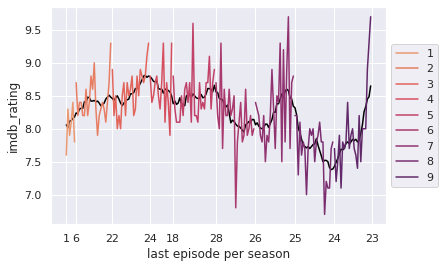

In [ ]:
#compare each season's ratings to the rolling average centered for every 10 episodes
df_index = df_original.reset_index()
#rolling average of imdb ratings for every 10 episodes
rolling_avg = df_index.rolling(window=10, center=True, on='episode', min_periods=1).mean()['imdb_rating']

#lineplot of rolling average
sns.lineplot(x='index',y=rolling_avg, data=df_index, color='black')
#time series of imdb ratings
df_index['season'] = df_index['season'].astype('category')
g= sns.lineplot(x='index', y='imdb_rating', hue='season', palette='flare', data=df_index)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_xlabel('last episode per season')
episode_labels = [1]
episode_ticks = [0]
for season_num in range(1,10):
  episode_labels.append(df_index[df_index['season']==season_num]['episode'].iloc[-1])
  episode_ticks.append(df_index[df_index['season']==season_num]['index'].iloc[-1] +1)
g.set_xticks(episode_ticks)
g.set_xticklabels(episode_labels)

#create a column of standardized imdb ratings
df_index['local_imdb_deviation'] = df_index['imdb_rating'] - rolling_avg


Firstly, we can see that the show was extremely popular throughout most of its running, with a notable exception toward the final seasons. There is then a dramatic spike in ratings toward the series finale. This immediately raises the question of what changed from the first half of the series to the second. Were there different characters? Different directors? A different weeknight slot? These are all things that we will consider throughout exploratory data analysis, feature selection and model fitting.
 

The primary question driving our predictive model is what makes a “good” episode? For our report, we have selected the threshold of an 8.6 rating, which is the $75^{\text{th}}$ percentile rating of all episodes. The logistic regression, then, will output the probability of an episode rating higher than 8.6. This threshold is customisable depending on the goals of the studio and executives.

We can look at the predictors available to us by examining the columns, or features, of the data:

In [ ]:
df_office.columns

Index(['season', 'episode', 'episode_name', 'director', 'writer',
       'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'main_chars'],
      dtype='object')

When trying to create a highly-rated episode, there are some key features that producers can control. For example, which characters get the most speaking time? Who are the writers? How long is the episode? Others, however, are not quite so straightforward to manipulate. For example, imagine that Season 8 was much more successful than other seasons, even to the extent that mediocre episodes that aired in Season 8 garnered higher ratings than funnier episodes in other seasons. If producers wanted to maximize the ratings for a new episode, they might want to release it in Season 8 - this, however, is clearly impossible!
 
Another example of a feature which isn't useful in our model is `total_votes`. The interesting thing about this feature is that, as we will see below, it actually has the highest correlation with `imdb_rating` among all other features. This would normally indicate that it would serve as a good predictor in a model; but producers cannot guarantee a certain number of votes for a reunion episode, so it doesn't make sense to include `total_votes` in the model.
 
We comb through each of the 13 provided features in a similar manner in order to determine those features which might be suitable for the model, as well as add in other features that might be relevant. For example, even though producers cannot directly use date (YYYY/MM/DD) to predict whether ratings will be good, they can certainly decide what day of the week to release a reunion episode.
 
Below is a brief summary of the features we have decided to consider as relevant for our model (no guarantee of including them in the final model yet!), as well as those features which are not useful for the purposes of this predictive model.
 
**Variables to consider**
- `director` (after some cleaning)
- `writer` (after some cleaning)
- `n_lines`
- `n_directions`
- `n_words`
- `n_speaking char`
- `main_chars` (after some cleaning)
 
**Variables not considered**
- `season`
- `episode`
- `episode_name`
- `total_votes`
- `air_date`
 
**Additional variables of interest**
- episode run time
- day of week
- day of month
- *individual* writers
- *individual* characters
- *individual* directors

As we have decided on a logistic regression, the first step of our data processing is to create a binary response variable for `imdb_rating` using a function we're calling `is_good_episode`. As discussed above, a threshold rating of 8.6 is used to determine a "good" episode. This can be modified, as it is an argument of the function. We then add a column to the data where 1 represents a "good" episode and 0 represents an average / bad episode.

In [ ]:
def is_good_episode (row, threshold = 8.6):
    '''
    Takes in rows from a data frame and creates the new column 'is_good' (1/0) based on 
    other columns imdb_rating from the data frame.
    '''
    if row['imdb_rating'] > threshold:
        return 1
    return 0

# Create the response variable
df_office['is_good_episode'] = df_office.apply (lambda row: is_good_episode(row), axis=1)

#df_office['is_good_episode'].value_counts()

#actually, I think we should include counts and discuss that since there are few
#positives, the LR might struggle to accurately predict TP

One of the primary variables of interest will be `run_time`, or episode duration; this, however, is not something that is included in the original data; rather, we scraped it directly from IMDb's website using the `urllib` and `BeautifulSoup` packages. Day of week and day of month can be easily extracted from the `air_date` column in the original data, while indicator variables for individual writers, directores and characters can be extracted from `writer` and `main_chars` using regular expressions. This is a bit of a computationally intensive process, so once scraped, we saved it as a csv file to upload at the start. The full code is commented below.

In [ ]:
# Code for scraping IMDB website for each episode's run time data 

# import urllib.request
# from bs4 import BeautifulSoup

# def extract_episode_info(url):
#   '''
#   Takes in url string 
#   Returns three integers (one each for season, episode and length of episode)
#   '''
#   with urllib.request.urlopen('https://www.imdb.com/' + url) as response:
#        html = response.read()
#        soup = BeautifulSoup(html, "html.parser")
#        run_time_info = soup.findAll("li", {"class": "ipc-inline-list__item"})
#        run_time = run_time_info[2].getText()[:-1]
#        season_ep = soup.findAll("span", {"class": "EpisodeNavigationForEpisode__SeasonEpisodeNumbersItem-sc-bji0pk-2 gwHgBk"})
#        #print(season_ep[0].string[1:], season_ep[1].string[1:])
#        episode_list = []
#        episode_list.append(season_ep[0].string[1:])
#        episode_list.append(season_ep[1].string[1:])
#        episode_list.append(run_time)
#        season_ep_runtime.append(episode_list)
       

# season_ep_runtime = []
# for s in range(1,10):
#     with urllib.request.urlopen('https://www.imdb.com/title/tt0386676/episodes?season='+str(s)) as response:
#         html = response.read()
#         soup = BeautifulSoup(html)
#         infos = soup.findAll("div", {"class": "info"})
#         for info in infos:
#           strong = info.findAll("strong")[0]
#           a = strong.findAll("a")[0]
#           url = a['href']
#           extract_episode_info(url)

# df_runtime = pd.DataFrame(data=season_ep_runtime, columns=["season","episode","run_time"])
# df_runtime.to_csv('run_time_data.csv')

The csv containing runtime data needs a bit of pre-processing before it can be merged with the existing data.

In [ ]:
# Data preperation to join runtime data to the office dataframe
df_runtime_data = pd.read_csv(io.BytesIO(uploaded2["run_time_data.csv"]))

# Some episodes were one hour long and we need to interpret that as 60 minutes
df_runtime_data['run_time'][df_runtime_data['run_time'] == 1] = 60

# Code to fix episode number ***************************************************
# can we clarify this?

df_office['episode_old'] = df_office['episode'].copy()
seasons = df_office['season'].unique()
j = 0
for seas in seasons:
  for ep in range(1,len(df_office[df_office['season']==seas])+1):
    #df['episode'][j] = ep
    df_office.loc[j, 'episode'] = ep
    j += 1

# Final join
df = pd.merge(df_office, df_runtime_data, on=['season', 'episode'], how='left')
df_pre = df.copy()

Whilst date is not a useful predictor by itself, we create features `day` and `month` to see if the time of week or time of year can be a useful predictor. We will then visualize their relationship with `imdb_rating`.

In [ ]:
def month_to_string(x):
  '''
  Function to turn month (as a number) to string
  '''
  if x == 1:
      return 'January'
  if x == 2:
      return 'February'
  if x == 3:
      return 'March'
  if x == 4:
      return 'April'
  if x == 5:
      return 'May'
  if x == 6:
      return 'June'
  if x == 7:
      return 'July'
  if x == 8:
      return 'August'
  if x == 9:
      return 'September'
  if x == 10:
      return 'October'
  if x == 11:
      return 'November'
  return 'December'


def day_to_string(x):

  '''
  Function to turn day (as a number) to string
  '''
  if x == 0:
      return 'Monday'
  if x == 1:
      return 'Tuesday'
  if x == 2:
      return 'Wednesday'
  if x == 3:
      return 'Thursday'
  if x == 4:
      return 'Friday'
  if x == 5:
      return 'Saturday'
  return 'Sunday'

# Create columns for month and day from air_date
df['month'] = pd.DatetimeIndex(df['air_date']).month
df['day'] = pd.DatetimeIndex(df['air_date']).weekday

# Month to string variable
df['month_string'] = df['month'].apply(month_to_string)
df['day_string'] = df['day'].apply(day_to_string)

No handles with labels found to put in legend.


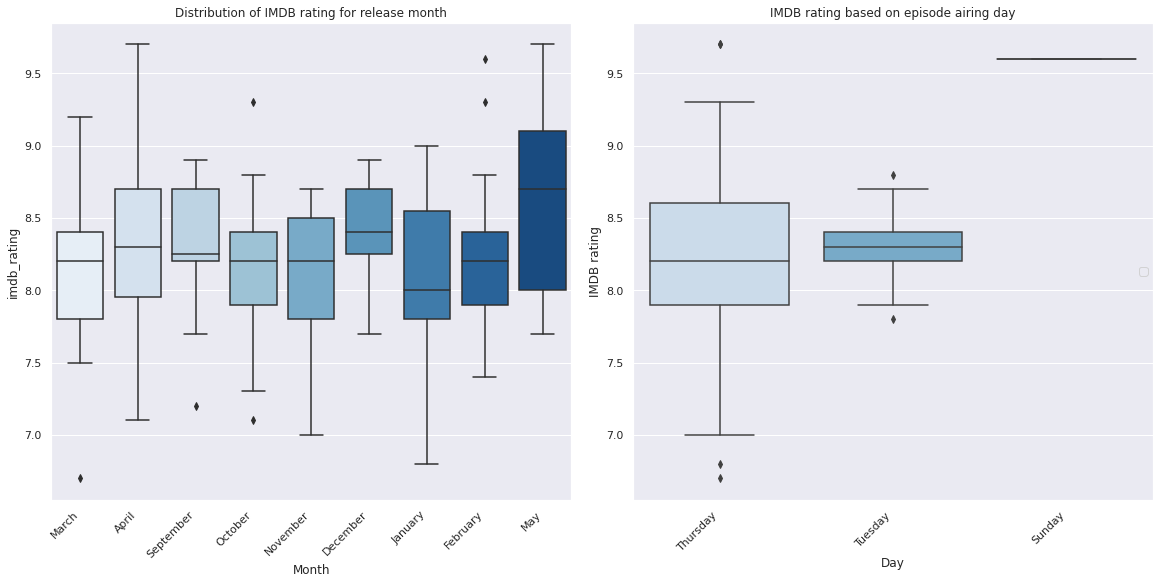

In [ ]:
# Create a boxplot, with month on the x axis, and IMDB rating on the y axis, 
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(16,8))
sns.set(style="darkgrid")
x1 = sns.boxplot(x="month_string", y="imdb_rating", data=df, ax=ax[0], palette="Blues") 
x2 = sns.boxplot(x="day_string", y="imdb_rating", data=df, ax=ax[1], palette="Blues") 

# Labels, legends, and axes
plt.legend(bbox_to_anchor=(1, 0.5)) 
ax[0].set_title("Distribution of IMDB rating for release month")
ax[1].set_title("IMDB rating based on episode airing day")
ax[0].set_xticklabels(ax[0].get_xticklabels(),                                   
                          rotation=45,                                    
                          horizontalalignment='right') 

ax[1].set_xticklabels(ax[1].get_xticklabels(),                                   
                          rotation=45,                                    
                          horizontalalignment='right') 
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Day")
plt.ylabel("IMDB rating")

# show plot
plt.show()    

We can see that the newly created `month` variables do seem to have some association with `imdb_rating`; May in particular is very highly rated. There is not a clear difference between Tuesdays and Thursdays, on the other hand. Sunday is an exception, and represents one special episode - this is discussed later in the report.

We have also created indicator variables for each of the main characters, directors and writers present in the original data. The code for this is written here.

In [ ]:
#################
# Data creation for characters
#################

# Loop through each episode
n,k = df.shape
actor_df = df.copy()

for i in range(0,n):

  # Extract main charactes for each episode
  main_char_list = actor_df['main_chars'][i].split(sep=';').copy()

  # Loop through and add to dic
  for name in main_char_list:

    # If the column is not present in the dataframe (create it)
    if name not in actor_df.columns:
      actor_df[name] = 0

    # Add 1 if the person is in the episode
    if name in actor_df.columns:
      actor_df.loc[i, name] = 1

# Here I want to create a dataframe that has the characters (actors) on 
# long format to more easily create plot and aggregate summary statistics
actors_d =  actor_df.iloc[:, k::].copy()
actors_d['imdb_rating'] = actor_df['imdb_rating'].copy()

actors_long = pd.melt(actors_d, id_vars=['imdb_rating'], 
                      value_vars=['Angela', 'Dwight', 'Jim', 'Kevin', 'Michael', 'Oscar', 'Pam',
       'Phyllis', 'Ryan', 'Stanley', 'Kelly', 'Toby', 'Meredith', 'Darryl','Creed', 'Andy', 'Erin'])


###################
## Data creation for writers
###################

writer_df = df.copy()

for i in range(0,n):

  # Extract writers for each episode
  main_char_list = writer_df['writer'][i].split(sep=';').copy()

  # Loop through and add to dict
  for name in main_char_list:

    # If the column is not present in the dataframe (create it)
    if name not in writer_df.columns:
      writer_df[name] = 0

    # Add 1 if the person wrote the episode
    if name in writer_df.columns:
      writer_df.loc[i, name] = 1


# Long format to more easily create plot and aggregate summary statistics
writer_d =  writer_df.iloc[:, k::].copy()
writer_d['imdb_rating'] = writer_df['imdb_rating'].copy()

writers_long = pd.melt(writer_d, id_vars=['imdb_rating'], 
                      value_vars=['Ricky Gervais', 'Stephen Merchant', 'Greg Daniels', 'B.J. Novak',
       'Paul Lieberstein', 'Michael Schur', 'Mindy Kaling', 'Gene Stupnitsky',
       'Lee Eisenberg', 'Larry Willmore', 'Jennifer Celotta', 'Steve Carell',
       'Brent Forrester', 'Justin Spitzer', 'Caroline Williams',
       'Lester Lewis', 'Ryan Koh', 'Aaron Shure', 'Charlie Grandy',
       'Anthony Q. Farrell', 'Warren Lieberstein', 'Halsted Sullivan',
       'Daniel Chun', 'Jason Kessler', 'Jonathan Huges', 'Peter Ocko',
       'Jon Vitti', 'Carrie Kemper', 'Steve Hely', 'Robert Padnick',
       'Amelie Gillette', 'Allison Silverman', 'Dan Greaney', 'Owen Ellickson',
       'Jonathan Green', 'Gabe Miller', 'Dan Sterling', 'Graham Wagner',
       'Nicki Schwartz-Wright', 'Tim McAuliffe'])


#######################
## Data creation for directors
#######################

director_df = df.copy()

for i in range(0,n):

  # Extract directors for each episode
  main_char_list = director_df['director'][i].split(sep=';').copy()

  # Loop through and add to dic
  for name in main_char_list:

    # If the column is not present in the dataframe (create it)
    if name not in director_df.columns:
      director_df[name] = 0

    # Add 1 if the person is in the episode
    if name in director_df.columns:
      director_df.loc[i, name] = 1


# Long format to more easily create plot and aggregate summary statistics
director_d =  director_df.iloc[:, k::].copy()
director_d['imdb_rating'] = director_df['imdb_rating'].copy()

director_long = pd.melt(director_d, id_vars=['imdb_rating'], 
                      value_vars=['Ken Kwapis', 'Ken Whittingham', 'Bryan Gordon', 'Greg Daniels',
       'Amy Heckerling', 'Paul Feig', 'Greg Daneils', 'Charles McDougall',
       'Dennie Gordon', 'Victor Nelli Jr.', 'Charles McDougal',
       'Ken Wittingham', 'Roger Nygard', 'Randall Einhorn', 'Miguel Arteta',
       'Tucker Gates', 'Jeffrey Blitz', 'Harold Ramis', 'Julian Farino',
       'Joss Whedon', 'J.J. Abrams', 'Craig Zisk', 'Paul Lieerstein',
       'Jason Reitman', 'Jennifer Celotta', 'David Rogers', 'Stephen Merchant',
       'Dean Holland', 'Asaad Kelada', 'Paul Lieberstein', 'Gene Stupnitsky',
       'Lee Eisenberg', 'Steve Carell', 'Brent Forrester', 'Reginald Hudlin',
       'Seth Gordon', 'B.J. Novak', 'John Krasinski', 'Marc Webb', 'Matt Sohn',
       'Mindy Kaling', 'Rainn Wilson', 'John Scott', 'Alex Hardcastle',
       'Danny Leiner', 'Michael Spiller', 'Troy Miller', 'Charlie Grandy',
       'Ed Helms', 'Eric Appel', 'Brian Baumgartner', 'Claire Scanlon',
       'Daniel Chun', 'Bryan Cranston', 'Claire Scanlong', 'Rodman Flender',
       'Kelly Cantley-Kashima', 'Lee Kirk', 'Jon Favreau', 'Jesse Peretz'])


# Create a column that is number of main characters in an episode
df['n_main_char'] = actor_df.iloc[:, k::].sum(axis=1)
df['n_writers'] = writer_df.iloc[:, k::].sum(axis=1)
df['n_directors'] = director_df.iloc[:, k::].sum(axis=1)

It is important to note that variables we are considering are not guaranteed to be included in the final model. In fact, we expect some of them to be so closely related with one another that adding one will provide no additional useful information and will instead needlessly complicate the model. In order to check this, we can plot a **correlation matrix** between variables which we would expect to be highly correlated. Specifically, `n_words`, `n_lines`, `n_speak_char` and `n_directions` should all increase as the length of an episode increases, so it might make sense to drop them in favor of `run_time`.

In [ ]:
# First examine correlation of imbd compared to other variables
corr_imdb_rating = df[df.columns[1:]].corr()['imdb_rating'][:]
print(corr_imdb_rating)

episode            0.143277
imdb_rating        1.000000
total_votes        0.653973
n_lines            0.348994
n_directions       0.226286
n_words            0.337212
n_speak_char       0.091992
is_good_episode    0.729772
episode_old        0.178164
run_time           0.457715
month             -0.000854
day                0.040266
n_main_char        0.072272
n_writers          0.147970
n_directors        0.075837
Name: imdb_rating, dtype: float64


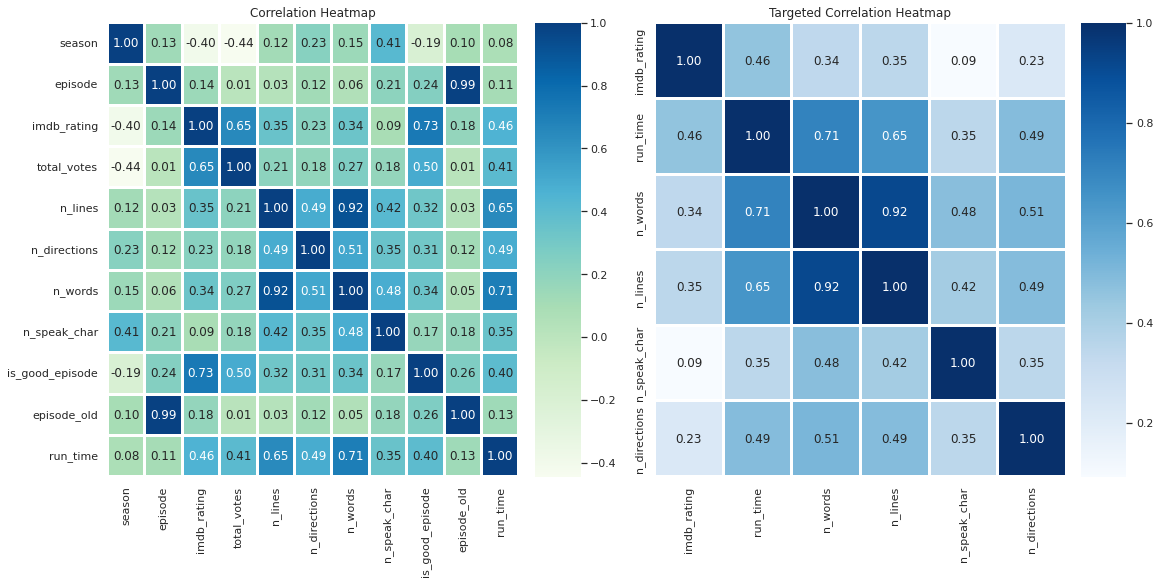

In [ ]:
# Correlation plots
fig, ax =plt.subplots(1,2, constrained_layout=True, figsize=(16,8))
sns.heatmap(df_pre.corr(), annot=True, fmt='.2f', linewidths=2, cmap="GnBu" ,ax=ax[0])
df_corr = df_pre[["imdb_rating", "run_time", "n_words", "n_lines", "n_speak_char", "n_directions"]]
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', linewidths=2, cmap='Blues', ax=ax[1])
ax[0].set_title("Correlation Heatmap")
ax[1].set_title("Targeted Correlation Heatmap")
fig.show()

It seems like `n_speak_char` is not very informative for imbd_rating. Given that there is moderate association between it and `n_words`, it might make sense to remove `n_speak_char`. The same can be said for `n_directions`.

`n_words` and `n_lines` are both slightly associated with `imdb_rating`, but a stronger relationship exists between `run_time` and `imdb_rating`. Note that both `n_words` and `n_lines` have a relatively strong association with `run_time` (as might be expected!), and so some of the correlation between `imdb_rating` and each of these covariates might be explained by `run_time`. If we examine the relationship between `imdb_rating` and `run_time` more closely, it is clear that `run_time` should be included in the model. The scatter plot below shows that as run time increases, the ratings tend to increase as well (although it should be noted that there are fewer data points for longer episodes). When comparing the distribution of `run_time` to our thresholds for good / bad episodes (rating of 8.6), it is also clear that good episodes have a higher mean run time than bad episodes.

We will therefore use **only** `run_time` among the covariates relating to episode length examined here in our model predicting `imdb_rating`. It is also important to note that `run_time` has a correlation coefficient of only 0.11 with `episode`, which indicates that season finales (which are rated higher) are not confounding the relationship between `run_time` and `imdb_rating`; rather, it seems that audiences genuinely enjoy longer episodes more, regardless of their placement within a season!

Text(0, 0.5, 'Run time')

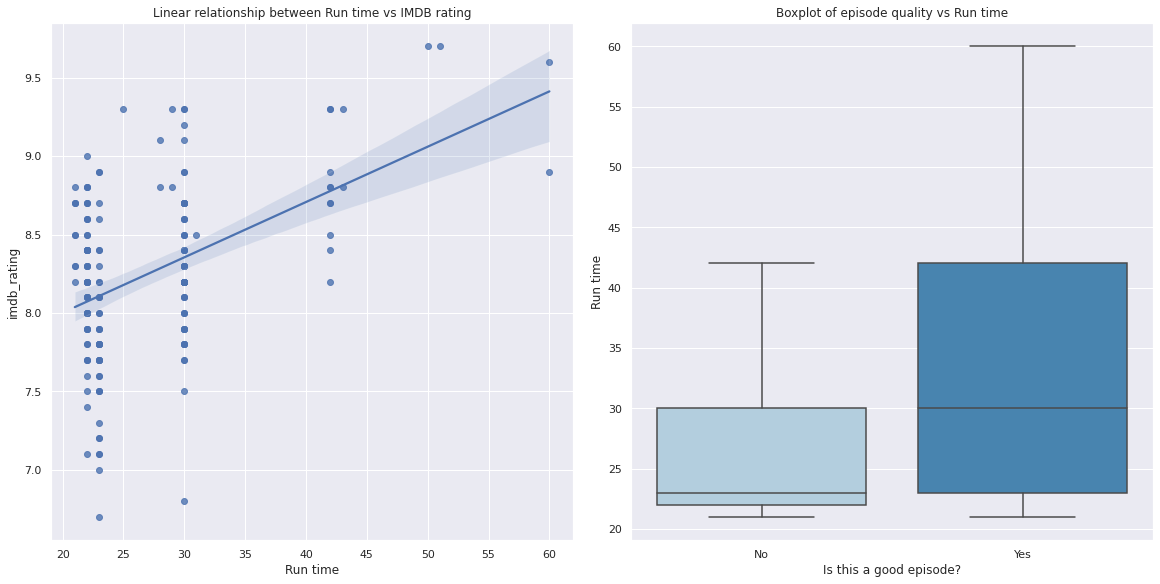

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(16,8))

sns.regplot(x='run_time', y='imdb_rating', data=df, ax=ax[0])

# Set title
ax[0].set_title("Linear relationship between Run time vs IMDB rating")
ax[1].set_title("Boxplot of episode quality vs Run time")

# Maybe add another feature x= episode good and y= runtime (boxplot)
sns.boxplot(x='is_good_episode', y='run_time', data=df, ax=ax[1], palette="Blues")

# if make sense add historgram of rating

# Set name of x axis
ax[0].set_xlabel("Run time")
ax[1].set_xlabel("Is this a good episode?")
ax[1].set_xticklabels(['No', 'Yes'])

# Set name of y axis
ax[0].set_ylabel("imdb_rating")
ax[1].set_ylabel("Run time")


Now that the threshold has been chosen and a new column created in our data, we can examine how individual characters, directors and writers perform relative to this threshold. 
 
An important note is that we are only considering writers who have been involved in at least 15 episodes, and only directors involved in at least 10. The reason here is that there are many guest directors and writers who have only been involved in one or two episodes, which is not representative of their performance in a reunion episode. By restricting our scope to directors and writers who have been consistently present, not only is the model computationally more efficient, we can have greater confidence in the model coefficients being informative. With that in mind, there are five writers and five directors who meet these thresholds (listed below); we will include them

Likewise, we are only considering main characters who appear in fewer than 160 episodes. Imagine a character, A, who was in all but two episodes. It is impossible to train a model on what the ratings would be if A was *not* in an episode, because the data on those occurrences is so limited. These characters are listed below.

In [ ]:
# Characters in fewer than 160 episodes
grouped_actors = actors_long.groupby(['variable']).aggregate(sum)

print(grouped_actors[grouped_actors['value'] < 160])

# Writers in more than 15 episodes
grouped_writers = writers_long.groupby(['variable']).aggregate(sum)
print(grouped_writers[grouped_writers['value'] >= 15])

# Directors in more than 10 episodes
grouped_director = director_long.groupby(['variable']).aggregate(sum)
print(grouped_director[grouped_director['value'] >= 10])

          imdb_rating  value
variable                    
Andy           1534.6    143
Creed          1534.6    131
Darryl         1534.6    105
Erin           1534.6     98
Kelly          1534.6    142
Meredith       1534.6    131
Michael        1534.6    137
Ryan           1534.6    139
Toby           1534.6    108
                  imdb_rating  value
variable                            
B.J. Novak             1534.6     15
Gene Stupnitsky        1534.6     15
Lee Eisenberg          1534.6     15
Mindy Kaling           1534.6     21
Paul Lieberstein       1534.6     16
                 imdb_rating  value
variable                           
Greg Daniels          1534.6     14
Jeffrey Blitz         1534.6     11
Ken Kwapis            1534.6     12
Paul Feig             1534.6     14
Randall Einhorn       1534.6     15


Now that we have decided which characters, directors and writers to consider for our model, we can visualize how each of them correspond to "good", "average" and "bad" episodes:

In [ ]:
# add chosen characters, writers and directors to main data frame

final_actors = actor_df[["season", "episode","Andy","Creed","Darryl","Erin","Kelly","Meredith","Michael","Ryan","Toby"]]
final_writers = writer_df[["season", "episode","B.J. Novak","Gene Stupnitsky","Lee Eisenberg","Mindy Kaling","Paul Lieberstein"]]

# Create an interaction variable between Gene Stupnitsky and Lee Eisenberg since
# They write almost all episodes together.
final_writers['Gene_Lee'] = final_writers['Gene Stupnitsky']*final_writers['Lee Eisenberg']
final_directors = director_df[["season", "episode","Greg Daniels","Jeffrey Blitz","Ken Kwapis","Paul Feig","Randall Einhorn"]]

df_join_1 = pd.merge(df, final_actors, on=['season', 'episode'], how='left')
df_join_2 = pd.merge(df_join_1, final_writers, on=['season', 'episode'], how='left')
df_join_3 = pd.merge(df_join_2, final_directors, on=['season', 'episode'], how='left')

df_final = df_join_3[['is_good_episode','imdb_rating','n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'run_time','month_string', 'day_string',
        'n_main_char','n_writers', 'n_directors',"Andy","Creed","Darryl","Erin",
 "Kelly","Meredith","Michael","Ryan","Toby","B.J. Novak","Gene Stupnitsky","Lee Eisenberg","Mindy Kaling","Paul Lieberstein",'Gene_Lee',
 "Greg Daniels","Jeffrey Blitz","Ken Kwapis","Paul Feig","Randall Einhorn"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


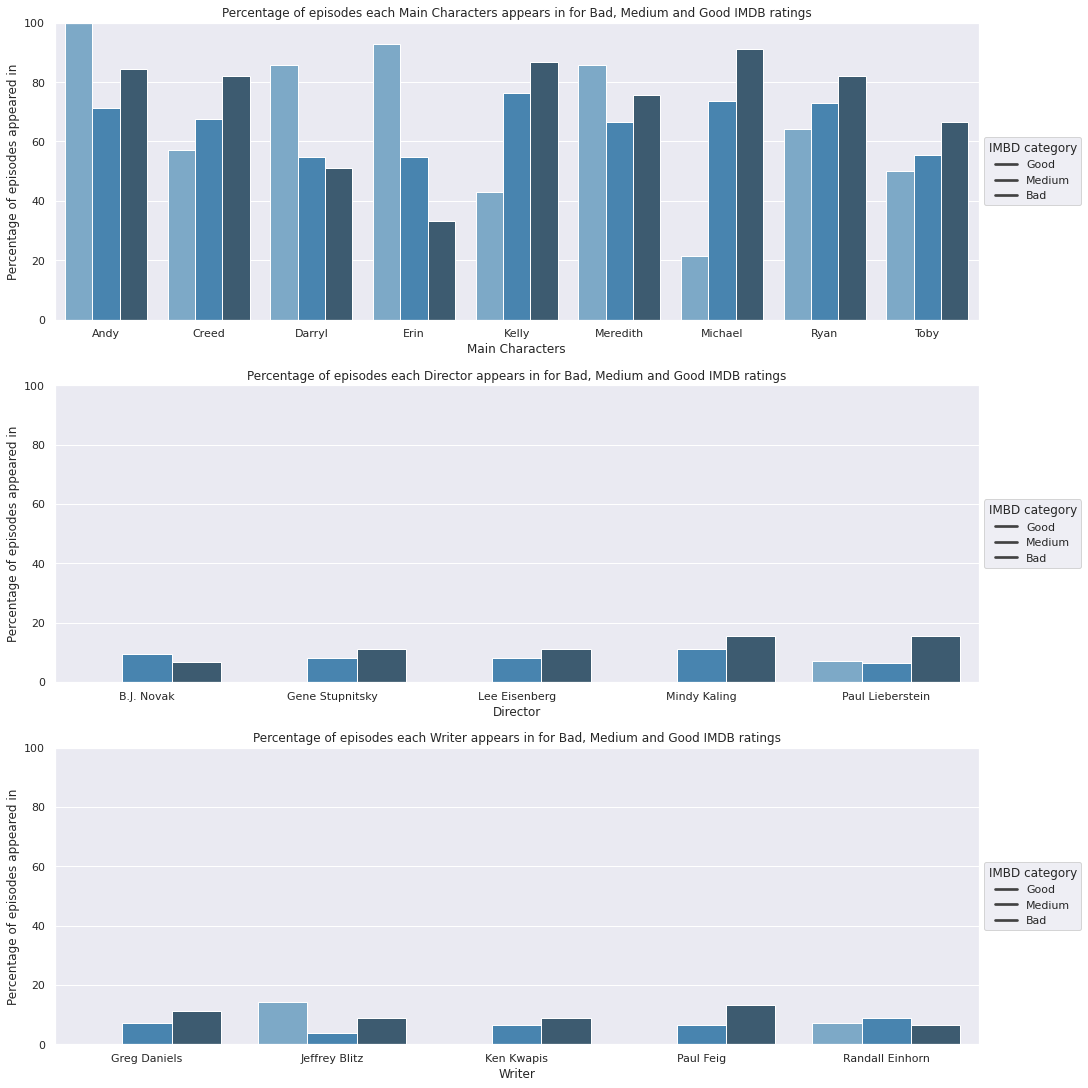

In [ ]:
#for each imdb rating, find proportion of episodes the actor appears in for categorised the imdb ratings into bad, medium and good bins
bins = pd.cut(df_final['imdb_rating'], [6.7, 7.5, 8.6, 9.7])
#group the actor's average appearance in episodes for each bin
#"Andy","Creed","Darryl","Erin",
# "Kelly","Meredith","Michael","Ryan","Toby","B.J. Novak","Gene Stupnitsky","Lee Eisenberg","Mindy Kaling","Paul Lieberstein",
# "Greg Daniels","Jeffrey Blitz","Ken Kwapis","Paul Feig","Randall Einhorn"
select_main_chars = ['Andy',"Creed","Darryl","Erin","Kelly","Meredith","Michael","Ryan","Toby"]
select_directors = ["B.J. Novak","Gene Stupnitsky","Lee Eisenberg","Mindy Kaling","Paul Lieberstein"]
select_writers = ["Greg Daniels","Jeffrey Blitz","Ken Kwapis","Paul Feig","Randall Einhorn"]
rating_bins_chars = df_final.groupby(bins).sum()[select_main_chars]
rating_bins_dirs = df_final.groupby(bins).sum()[select_directors]
rating_bins_writers = df_final.groupby(bins).sum()[select_writers]

for df in [rating_bins_chars, rating_bins_dirs, rating_bins_writers]:
  for i in range(3):
    df.iloc[i,:] = (df.iloc[i,:]/df_final.groupby(bins).size()[i])*100

rating_bins_chars, rating_bins_dirs, rating_bins_writers = [
    df.reset_index()
    for df in [rating_bins_chars, rating_bins_dirs, rating_bins_writers]
]
rating_bins_chars, rating_bins_dirs, rating_bins_writers = [
   pd.melt(df[0], id_vars=['imdb_rating'], value_vars=df[1])
   for df in [[rating_bins_chars, select_main_chars], [rating_bins_dirs, select_directors], [rating_bins_writers, select_writers]]
] 
 #plot average episodes actor appears in for each imdb rating category - bad, medium and good.
plt.rcParams['figure.figsize'] = 11.7,8.27

def barplot(df_rating, x_labels):
  fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(15, 15))
  for i in range(len(df_rating)):
    sns.barplot(x='variable', y='value', hue='imdb_rating', data=df_rating[i], palette="Blues_d", ax=ax[i])
    ax[i].legend(["Good","Medium","Bad"], loc='center left', bbox_to_anchor=(1, 0.5), title = "IMBD category")
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_title('Percentage of episodes each ' + x_labels[i] + ' appears in for Bad, Medium and Good IMDB ratings')
    ax[i].set_ylabel("Percentage of episodes appeared in")
    ax[i].set_ylim((0,100))


barplot(df_rating = [rating_bins_chars, rating_bins_dirs, rating_bins_writers], x_labels = ['Main Characters', 'Director', 'Writer'])


Michael is a clear standout when comparing episodes in which he is a main character to those in which he is not. Erin, on the other hand, is present in more episodes with lower ratings. The influence of other characters is not as clear; we include them in the model to see whether their presence is significant or not.

Among writers, Mindy Kaling and Paul Lieberstein seem to be present in a larger percentage of good episodes than their peers.

Among directors, although it is not quite as clear, Greg Daniels and Paul Feig have a higher proportion of "good" episode than other directors.

We will bear these observations in mind during our model fitting and analysis.

Now, we are ready for the model fitting. The final analysis we did before fitting a model was to check for NA values and duplicates, and there were no missing values or duplicates in our data.

In [ ]:
# Data checks ************* Do we really need this? ****************************

# Check duplicated values 
# As there are not duplicated values we wont need resamples
#print("There are {} duplicated observations \n".format(df_final.duplicated().sum()))

# Check for NA values
#print("There are Na values per colum \n{}".format(df_final.isna().sum())) 


In [ ]:
# What was special about the 40, 50, and 60 minute episodes? Season finales? More characters?
# print(df['imdb_rating'].groupby(df['run_time']).describe())
# df[df['run_time']>40].groupby('main_chars').count()

# df[df['run_time']>40].groupby('episode').count()


#Comment: More number of characters for 8 of the 16 episodes with run time over 40 mins. Their min Imdb ratings are all above 8.2 with the max values all above 9.3 (higher than all max).
#The std is lower than for other run times as well.  


In [ ]:

#g = sns.lmplot(y="imdb_rating", x="run_time", hue='n_main_char', col="n_main_char",
#               data=df, height=6, aspect=.4, x_jitter=.1)
#g = sns.lmplot(y="imdb_rating", x="run_time", hue='n_writers', col="n_writers",
#               data=df, height=6, aspect=.4, x_jitter=.1)
#g = sns.lmplot(y="imdb_rating", x="run_time", hue='n_directors', col="n_directors",
#               data=df, height=6, aspect=.4, x_jitter=.1)
#g = sns.lmplot(y="imdb_rating", x="run_time", hue='day', col="day",
#               data=df, height=6, aspect=.4, x_jitter=.1)

#For episodes aired on Thursday, higher run times showed higher ratings, the run time vs imdb rating is linear and positive.

In [ ]:
# Maybe we dont need this one, just keep code

#df_final.head()
# Analize which characters need to be in based on the ratings

# fig = plt.figure()
# fig.set_size_inches(20, 10.5)
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# ax = fig.add_subplot(2, 5, 1)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Michael')
# ax = fig.add_subplot(2, 5, 2)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Andy')
# ax = fig.add_subplot(2, 5, 3)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Darryl')
# ax = fig.add_subplot(2, 5, 4)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Creed')
# ax = fig.add_subplot(2, 5, 5)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Erin')
# ax = fig.add_subplot(2, 5, 6)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Kelly')
# ax = fig.add_subplot(2, 5, 7)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Meredith')
# ax = fig.add_subplot(2, 5, 8)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Ryan')
# ax = fig.add_subplot(2, 5, 9)
# sns.histplot(data = df_final, x= 'imdb_rating', hue='Toby')
# plt.show()

## 3. Model Fitting and Tuning


*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

********************************************************************************

As discussed in the introduction, we are implementing a logistic regression to predict the probability of an episode with certain features rating above 8.6 on IMDb. We also considered the use of a linear regression model, ridge regression, and lasso regression to predict the IMDb score of the chosen episode, but ultimately felt that a logistic regression offered better interpretability, and is more clear about the uncertainty associated with prediction. It's easier to reason to an NBC Universal executive that an episode with certain features has $x\%$ probability of being a good episode compared to arguing that an episode will get a rating of $x$ on IMDb.
 
Both linear and logistic regression fall under the umbrella of supervised learning, wherein a desired response variable is known ahead of time. Although unsupervised learning can lead to interesting insights in terms of the similarities between episodes (using clustering methods, for example), a supervised learning model is more relevant for our report, as we are interested in predicting whether the IMBd rating is good or not.

As mentioned in the exploratory chapter above, we decided to drop features that were highly correlated with running time. However, during model refinement, we did try to include some of these variables and found that they added no extra predictive value. Specifically, at the start of the modelling refinment we had variables run time of an episode, number of main characters, writers and directors, weekday and month of the air time for the episode, main characters in an episode (for example 1/0 if Michael was in an episode or not) and similar variables for writers and directors. See the discussion about those variables in the chapter above.
 
In order to better determine which parameters are significant, we firstly scale all numeric features using SciKitLearn’s `StandardScaler` transformer. Then, we use the `l1` parameter of logistic regression to implement a penalty which reduces the regression coefficients. This also serves to drive any non-informative parameters to zero. Finally, we conduct a “grid search” to find the optimal penalty value using `GridSearchCV`; we choose `C=1.0212` in this case.

In [ ]:

df_final_dummies = pd.get_dummies(df_final[['is_good_episode', 'run_time',
                                            'month_string', 'day_string',
        "Andy","Creed","Darryl","Erin",
 "Kelly","Meredith","Michael","Ryan","Toby","B.J. Novak",
 "Gene_Lee"
 ,"Mindy Kaling","Paul Lieberstein",
 "Greg Daniels","Jeffrey Blitz","Ken Kwapis","Paul Feig","Randall Einhorn"]],
  columns=["month_string", "day_string"],drop_first=True)


X = df_final_dummies.drop('is_good_episode',axis=1) 
y = df_final_dummies['is_good_episode'] 

# Split data into test train and stratify based on y
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=23,
                                                    stratify = y, 
                                                    shuffle=True)


In [ ]:
# Pick variables to scale
#numeric_features = ['run_time', 'n_main_char','n_writers','n_directors']
numeric_features = ['run_time']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Fit a pipeline
logist_pipeline = make_pipeline(
        numeric_transformer,
        LogisticRegression(penalty='l1', solver='liblinear')
    )

# Grid search for C
param_grid = {'logisticregression__C': np.linspace(0.1, 2, num=100) }
gs_fit = GridSearchCV(
    logist_pipeline,
    param_grid=param_grid,
    scoring = ["accuracy", "f1","recall","precision"],
    cv=StratifiedKFold(n_splits=6,shuffle=True,random_state=1234),
    refit = "f1"
).fit(X_train, y_train)


gs_fit.best_params_

{'logisticregression__C': 1.0212121212121212}

As mentioned before a l1 penalty for logistic regression was used to shrink variables that seem to be reduntant in deciding whether an episode is "good" or not. As we can see from the output below variables like:

*   Number of main characters
*   Daryll being in an episode
*   Toby being in an episode
*   B.J. Novak directing an episode
*   Paul Feig writing an episode
*   What day of week to relase

Seem to have no predictive power for the final model chosen.

In [ ]:
print(gs_fit.best_params_)

for item in list(zip(gs_fit.best_estimator_.steps[-1][1].coef_.reshape((29,)), X_train.columns)):
  print(item)

{'logisticregression__C': 1.0212121212121212}
(0.6915006912716861, 'run_time')
(0.48616188643031927, 'Andy')
(0.11214738303425142, 'Creed')
(0.0, 'Darryl')
(-1.0289313025685372, 'Erin')
(0.054002451555568945, 'Kelly')
(0.15446762553646978, 'Meredith')
(0.4992723678690232, 'Michael')
(0.39279972535232144, 'Ryan')
(0.007897100389135093, 'Toby')
(0.0, 'B.J. Novak')
(-0.28081027722027396, 'Gene_Lee')
(0.08048724817050665, 'Mindy Kaling')
(0.07242273219411889, 'Paul Lieberstein')
(0.07695016567476362, 'Greg Daniels')
(-0.13096204027209923, 'Jeffrey Blitz')
(0.0, 'Ken Kwapis')
(0.0, 'Paul Feig')
(-0.1556990712802045, 'Randall Einhorn')
(0.0, 'month_string_December')
(-0.20710022813173481, 'month_string_February')
(-0.10671699090617065, 'month_string_January')
(-0.22331037186983088, 'month_string_March')
(0.703337128521432, 'month_string_May')
(-0.7512828120076287, 'month_string_November')
(-0.554990965739284, 'month_string_October')
(0.09773431131646315, 'month_string_September')
(0.0, 'day_

Now that we have fit the model, we conduct model evaluation by using the model to predict rating classification for test data. To be certain that our model is performing as expected we want the model to have good accuracy as well as good discriminatory power. 

The possible outcomes from our model can be briefly summarized as:
- Correctly identify a good episode as good (true positive, TP)
- Incorrectly label a good episode as bad (false negative, FN)
- Incorrectly label a bad episode as good (false positive, FP)
- Correctly label a bad episode as bad (true negative, TN)
 
We can visualize this outcome by comparing True Positive Rate ($\text{TPR}=\frac{\text{TP}}{\text{TP+FN}}$) to False Positive Rate ($\text{FPR}=\frac{\text{FP}}{\text{FP+TN}}$) based on different cut off points for labeling (1/0) using an ROC curve. The farther the curve is from the “random classifier” (which always has equal TPR and FPR values), the better the model performs. This can be quantified using the area under the curve (AUC), where an AUC of 0.5 represents a random classifier, and an AUC of 1 represents a model that has a perfect classification rate on test data. The model we have constructed has an AUC of 0.78, which is quite good, given the variability inherent in what factors determine whether audiences rate a show highly or not. We have high confidence in this model correctly classifying an arbitrary show with certain features provided, namely a reunion episode.

Below the ROC curve we can see the confusion matrix. Our model seems to be doing a very good in predicting true negative values for the test set. However, it is still having difficulties in predicting the true positive values, which is what we are looking for. We will discuss this further in chapter 4 of the report.


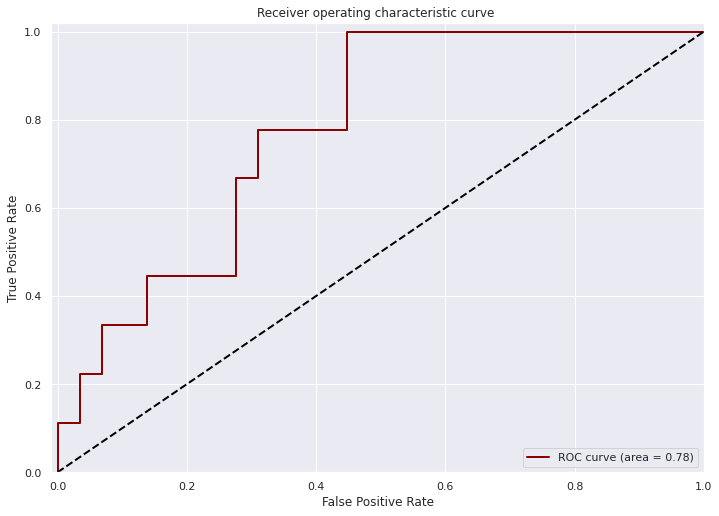

In [ ]:
#Plotting a ROC curve

# Get predictions (of probabilities)
pred = gs_fit.predict_proba(X_test)[:,1]

# Use the ROC curve to measure the accuracy of the model
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

# True positive rate vs false positive rate
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkred",
    lw=lw,
    label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr),
)
# Set the axes (0,1) for x and y
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve ")
plt.legend(loc="lower right")
plt.show()

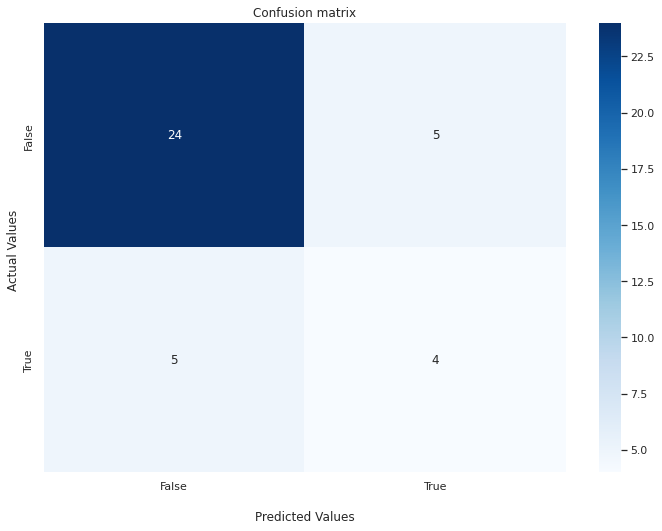

In [ ]:
cm = confusion_matrix(y_test, gs_fit.predict(X_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Labels for confusion matrix
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

********************************************************************************
# 4. Discussion
 
The results of the logistic regression clearly highlight Michael, Ryan and Andy as popular characters, while Erin should probably not be included in the reunion episode. Compared to **baseline odds** of 0.33 (since 25% of shows are labeled "popular" by our choice of threshold), shows in which Erin is a leading character are on average 35.7% as likely to be highly rated as those in which she isn’t (this equates to odds of roughly 1 in 9). Shows in which Michael is present, on the other hand, have 1.6 times better odds of be highly rated - over 1 in 2. Episodes in which Andy or Ryan feature are likewise much more likely to be highly rated than those without one of them.
 
Amongst choices for writers, Mindy Kaling seems to have the most positive impact on rating, with a 8.4% improvement compared to episodes without her as a writer; although the odds of Kaling writing a highly rated show is only 0.81% higher compared to the next-best predicted writer, Paul Lieberstein. Either would realistically be a good option for writing the reunion episode.
 
Among directors, Greg Daniels is the highest performing. Shows which he directed have an 8% higher odds of rating well than the next-best predicted director, Paul Feig.
 
“The Office” was only ever released on Tuesday or Thursday, with one exception. Season 5 episode 86/87 (“Stress Relief”) is a two-part episode that aired after Super Bowl XLIII on 1 February 2009. While the regression output indicates that the day of week is not relevant to the odds of being a highly rated episode, it is worth noting that such exceptional releases might rate very highly; indeed, this episode is one of the most highly-rated in the show’s history. There is, unfortunately, not enough occurrences of these events to come to any concrete conclusions.
 
Although the day of the week is not relevant to ratings, the month certainly seems to be. We observed in our exploratory data analysis that ratings seemed to be strongest in May, and indeed the regression coefficient for `month_string_May` indicates that a May release (the best performing month) has 95.3% better odds of higher ratings than a November release (the worst performing month).

In [ ]:
# Handpicked episode
X_new = np.array([50,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0])

X_test_new = X_test.append(pd.DataFrame(X_new.reshape(1,-1), columns=list(X_test)), 
                           ignore_index=True)

print(f"Probability for a hand picked episode: {round(gs_fit.predict_proba(X_test_new)[-1,1],4)}")

Probability for a hand picked episode: 0.9978
